## Time Series Analysis and Forecasting

import needed libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np     
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit 
from itertools import product    
from dateutil.relativedelta import relativedelta
from datetime import date, timedelta
import warnings                                 
warnings.filterwarnings('ignore')
get_ipython().magic(u'matplotlib inline')

Function to normalize data and calculate mean_absolute_percentage_error

In [5]:
from statsmodels.tsa.arima_model import ARIMA

def dataNorm(series, maxVal, which ="n"):
    if(which == "n"):
        result = series/maxVal
    elif(which == "d"):
        result = series*maxVal
    else :
        result = NullType
    return result

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Function to find the best ARIMA model for the current input dataset


In [6]:
def optimizeARIMA(series, parameters_list):
    """
        Return dataframe with parameters and corresponding AIC
        parameters_list - list with (p, d, q) tuples
    """
    
    results = []
    best_aic = float("inf")
    for param in parameters_list:
        try:
                model = sm.tsa.ARIMA(series, order=(param[0], param[1], param[2])).fit(disp=-1)
        except:
                continue
                        
        aic = model.aic

        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    return result_table



Function to plot ARIMA results w.r.t original dataset.  
various things have been tried in this function to plot the model in different ways.  
Hence the commented out parts.

In [56]:
def plotARIMA(series, model, forecast, maxVal):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data = dataNorm(data,  maxVal=maxVal, which="d")  
    data.columns = ['actual']
    data['arima_model'] = dataNorm(model.fittedvalues, maxVal=maxVal, which="d")  
    data[data['arima_model'] < 0] = 0
#     data['arima_model'] = dataNorm(forecast, maxVal=maxVal, which="d")
    forecast = dataNorm(forecast, maxVal=maxVal, which="d")  
    full_forecast = data.arima_model.append(forecast)
#     full_forecast = forecast
    full_forecast = full_forecast.resample('M',how='sum')
    data = data.resample('M',how='sum')

#     # calculate error, again having shifted on s+d steps from the beginning
#     error = mean_absolute_percentage_error(data['actual'], data['arima_model'])
    error = mean_absolute_percentage_error(data['actual'], data['arima_model'])
    plt.figure(figsize=(15, 7))
#     plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.title("Forecasting Expenses")
    plt.plot(full_forecast, color='#ff6200', label="model")
    plt.axvspan(data.index[-1], full_forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual,color='#666666', label="actual")
    plt.legend()
    plt.grid(True);
    plt.show()


function to prepare data for train, test

In [8]:
def prepareData(series, test_size):
    split_point = int(len(series)* (1-test_size)) 
    print(split_point)
    train, test = series[0:split_point], series[split_point:]
    return train,test

## load the files and build ARIMA model for each dataset

In [52]:
df  = pd.read_csv('expensesDataFile.txt')   
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d' )
df['expenses']= pd.to_numeric(df['expenses'])
df = df.groupby(['date']).sum().reset_index()
df.set_index('date',inplace=True)


df1 = df.copy()
# df1[np.abs(df1.expenses - df1.expenses.mean()) >= (3 * df1.expenses.std())] = df1.expenses.mean() # + (3 * df1.expenses.std())
df1 = df1.asfreq('D')
df1.fillna(0, inplace=True)

maxVal = df1.expenses.max()
df1 = dataNorm(df1,maxVal=maxVal,which="n") 

creating parameters and finding the best model for dataset

In [53]:
p = range(0, 4)
d = range(0,2)
q = range(0, 4)

# creating list with all the possible combinations of parameters

parameters = product(p, d, q)
parametersList = list(parameters)
print(len(parametersList))

# not currently used
# trainingData, testingData = prepareData(df1, 0.3)

resultsTable = optimizeARIMA(df1.expenses, parametersList)
p,d,q = resultsTable.parameters[0]
print(p,d,q)

32
2 0 3


Use the best model and plot the results

-837.8098105323102


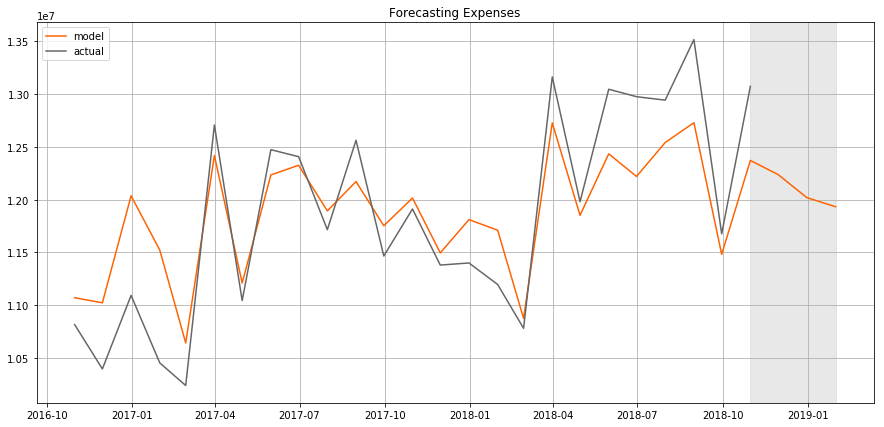

In [57]:
bestModel = sm.tsa.ARIMA(df1.expenses, order=(p,d,q) ).fit()
print(bestModel.aic)

dataRows = df1.expenses.count()
# trainCount = trainingData.net_charge.count()
# testCount  = testingData.net_charge.count()
lastDate = date(df1.index.year[-1:][0], df1.index.month[-1:][0], df1.index.day[-1:][0])
forecastEndDate = lastDate + relativedelta(months=3)
forecastCount = (forecastEndDate - lastDate ).days - 1

forecast = bestModel.predict(start= dataRows, end = dataRows + forecastCount )
# forecast = best_model.predict(start= trainCount, end = trainCount + testCount -1  )
forecast[forecast<0]= 0
plotARIMA(df1 ,bestModel, forecast, maxVal)
